In [1]:
import pickle
import os
import lc_model as model
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import parallel_simulation as sim
from sklearn.model_selection import train_test_split

Batch 8 for worker 0 not found.
Batch 9 for worker 0 not found.
Batch 10 for worker 0 not found.
Batch 11 for worker 0 not found.
Batch 12 for worker 0 not found.
Batch 13 for worker 0 not found.
Batch 14 for worker 0 not found.
Batch 15 for worker 0 not found.
Batch 16 for worker 0 not found.
Batch 17 for worker 0 not found.
Batch 18 for worker 0 not found.
Batch 19 for worker 0 not found.
Batch 20 for worker 0 not found.
Batch 21 for worker 0 not found.
Batch 22 for worker 0 not found.
Batch 23 for worker 0 not found.
Batch 24 for worker 0 not found.
Batch 25 for worker 0 not found.
Batch 26 for worker 0 not found.
Batch 27 for worker 0 not found.
Batch 28 for worker 0 not found.
Batch 29 for worker 0 not found.
Batch 30 for worker 0 not found.
Batch 31 for worker 0 not found.
Batch 32 for worker 0 not found.
Batch 33 for worker 0 not found.
Batch 34 for worker 0 not found.
Batch 35 for worker 0 not found.
Batch 36 for worker 0 not found.
Batch 37 for worker 0 not found.
Batch 38 for

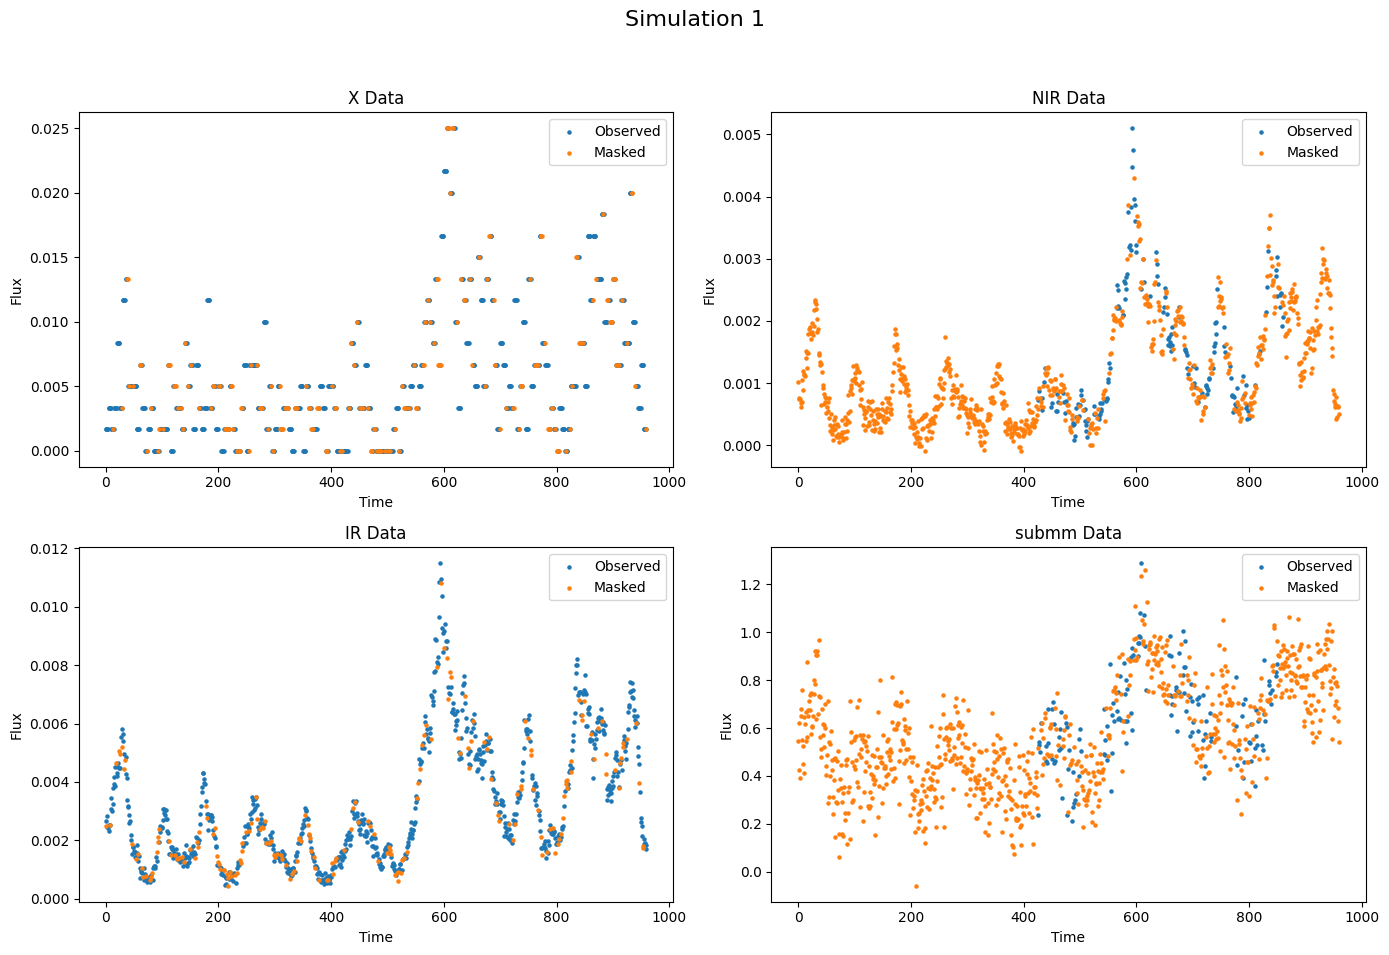

In [2]:
num_simulations = 3200
batch_size = 50
num_batches = num_simulations // batch_size + (1 if num_simulations % batch_size != 0 else 0)
num_workers = 8

all_data = sim.Simulation.load_all_data(num_batches, num_workers)
print(len(all_data))
# len(all_data)
sim_number = 1
sim.Simulation.plot_simulation(all_data[sim_number - 1]['data'], sim_number, 2) # -1 because indexing starts at 0
# simulation.Simulation.plot_all_simulations(all_data)

In [3]:
# Constants
num_examples = len(all_data)
timesteps = 960
channels = 4  # Corresponds to X, NIR, IR, submm

# Initialize a full data array
full_data = np.zeros((num_examples, timesteps, channels * 2 + 1))

# Function to fill in the data array
def fill_data_array(data_array, data_list):
    for i, data_entry in enumerate(data_list):
        for j, key in enumerate(["X", "NIR", "IR", "submm"]):
            # Retrieve unmasked and masked y-values and their corresponding x indices
            ydata_unmasked = np.array(data_entry['data'][key]["ydata_unmasked"])
            xdata_unmasked = np.array(data_entry['data'][key]["xdata_unmasked"])
            ydata_masked = np.array(data_entry['data'][key]["ydata_masked"])
            xdata_masked = np.array(data_entry['data'][key]["xdata_masked"], dtype=int)

            # Fill in unmasked data at the correct time step indices
            data_array[i, xdata_unmasked, j] = ydata_unmasked
            data_array[i, xdata_masked, j] = ydata_masked
            
            # Create a mask: 1 for observed (unmasked), 0 for masked
            mask = np.zeros(timesteps)
            mask[xdata_unmasked] = 1  # Mark unmasked data as observed
            data_array[i, :, channels + j] = mask  # Fill the mask array
        
        # Time progression: assuming it ranges from 0 to 1 over 960 timesteps
        data_array[i, :, -1] = np.linspace(0, 1, timesteps)

# Fill the full data array
fill_data_array(full_data, all_data)

# Split the data into train, validation, and test sets
train_data, temp_data = train_test_split(full_data, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.4, random_state=42)

# Save to .npz file
np.savez("sgra_data.npz", train=train_data, val=val_data, test=test_data)


In [9]:
def plot_random_example(file_path):
    # Load the .npz file
    data = np.load(file_path)
    
    # Combine the train, val, and test data to pick a random example from all data
    all_data = np.concatenate([data['train'], data['val'], data['test']], axis=0)
    
    # Select a random example
    random_index = 2999
    # random_index = np.random.randint(all_data.shape[0])
    example = all_data[random_index]
    
    timesteps = example.shape[0]
    channels = 4  # X, NIR, IR, submm
    
    # Create a figure with subplots for each channel
    fig, axes = plt.subplots(channels, 1, figsize=(10, 8), sharex=True)
    time = np.linspace(0, 1, timesteps)
    
    for j, key in enumerate(["X", "NIR", "IR", "submm"]):
        # Retrieve the data and mask for this channel
        ydata = example[:, j]
        mask = example[:, channels + j]
        
        # Plot observed data (where mask is 1)
        axes[j].scatter(time[mask == 1], ydata[mask == 1], color='blue', label='Observed', s=1)
        # Plot masked data (where mask is 0)
        axes[j].scatter(time[mask == 0], ydata[mask == 0], color='orange', label='Masked', s=1)
        
        # Label the subplot
        axes[j].set_ylabel(key)
        axes[j].legend()
    
    # Set common labels
    axes[-1].set_xlabel("Normalized Time")
    plt.suptitle("Random Example from Formatted Data")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Usage
plot_random_example("sgra_data.npz")

FileNotFoundError: [Errno 2] No such file or directory: 'sgra_data.npz'